This notebook provides –∞n example of Hull-White Model

‚úÖ –ö–∞–ª–∏–±—Ä–æ–≤–∞–Ω–Ω—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã: a = 0.0010, sigma = 0.0100



üìä –°—Ä–∞–≤–Ω–µ–Ω–∏–µ —Ü–µ–Ω ZCB:
1Y: Market = 0.959541, Model = 0.959561, Diff = 1.980813e-05
2Y: Market = 0.922932, Model = 0.920795, Diff = -2.136376e-03
5Y: Market = 0.815055, Model = 0.813846, Diff = -1.209140e-03
10Y: Market = 0.638266, Model = 0.663025, Diff = 2.475938e-02


üìà –°–∏–≥–Ω–∞–ª –æ—Ç —Å–∏–º—É–ª—è—Ü–∏–∏ —Å—Ç–∞–≤–æ–∫: 0 (1=long, -1=short, 0=neutral)
‚Üí r0 = 0.0413, mean = 0.0412, std = 0.0098

üìä –°—Ç—Ä–∞—Ç–µ–≥–∏—è –Ω–∞ –æ—Å–Ω–æ–≤–µ Hull-White —Å–∏–º—É–ª—è—Ü–∏–∏:
Sharpe: nan
Max Drawdown: 0.00%


C:\Users\Admin\AppData\Local\Temp\ipykernel_18428\696766697.py:197: RuntimeWarning: invalid value encountered in scalar divide
  sim_sharpe = sim_strategy.mean() / sim_strategy.std() * np.sqrt(252)



üìà Summary Table:
      Strategy    Sharpe  Max Drawdown      CAGR
             a -1.832418     -0.022074 -0.018074
             œÉ -0.512079     -0.014862 -0.006736
      combined -1.155680     -0.018329 -0.015268
simulated (HW)       NaN      0.000000  0.000000


C:\Users\Admin\AppData\Local\Temp\ipykernel_18428\696766697.py:228: RuntimeWarning: invalid value encountered in scalar divide
  sharpe = series.mean() / series.std() * np.sqrt(252)


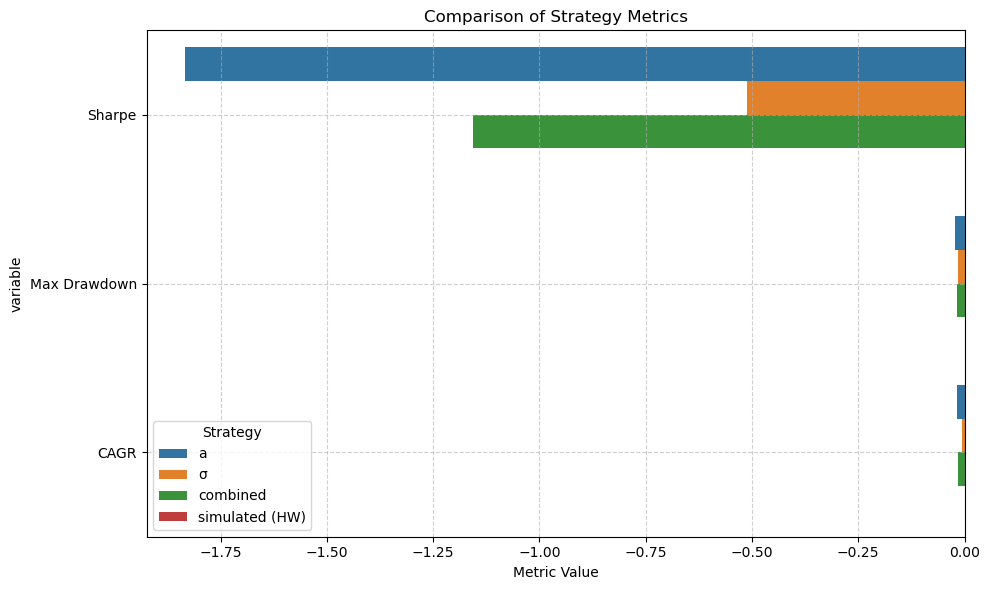

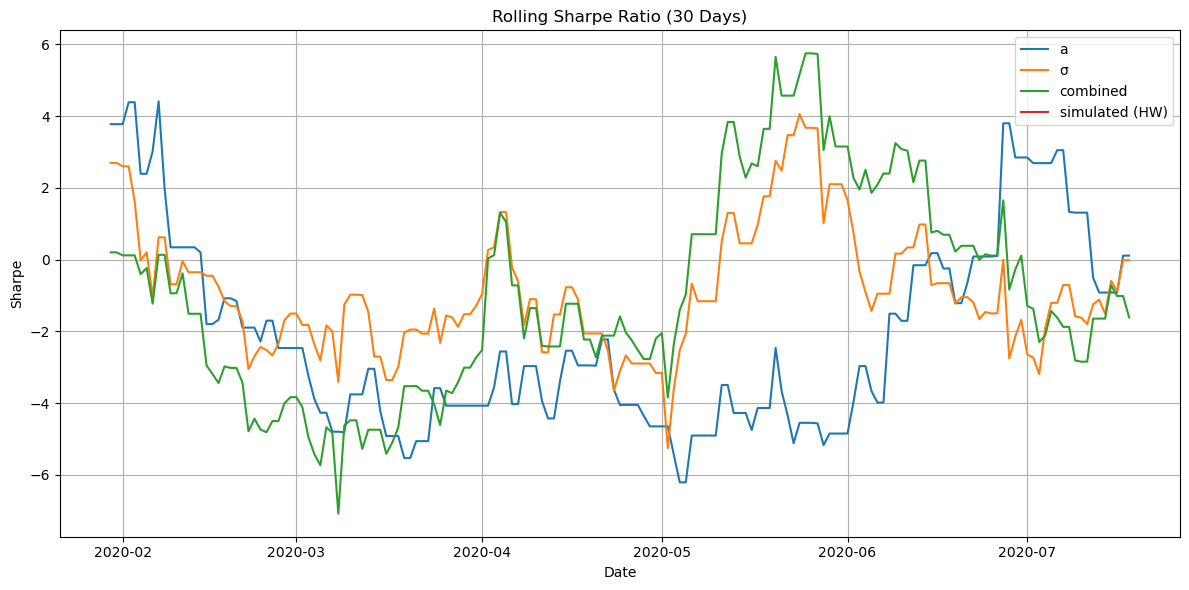

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


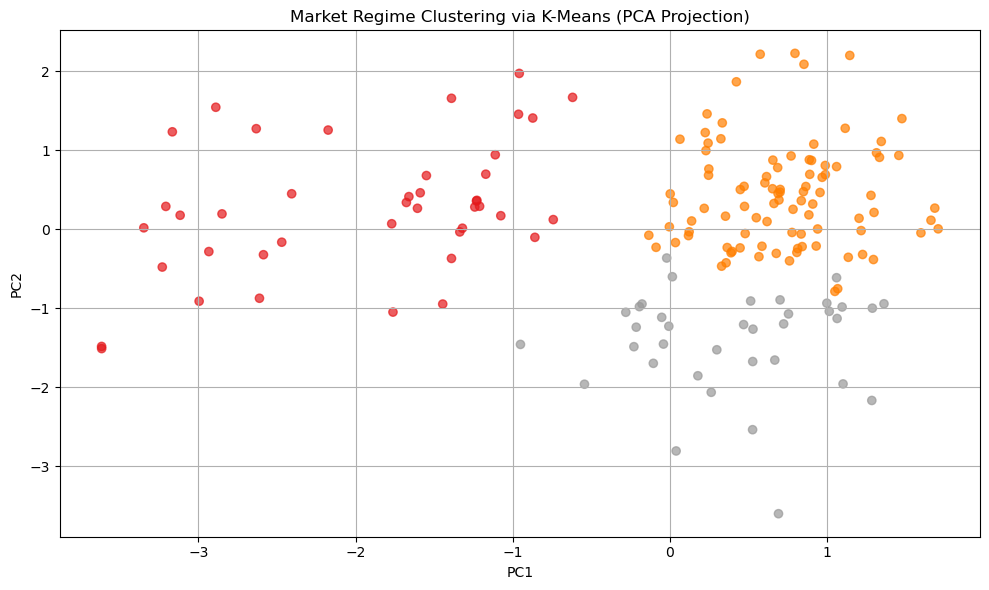

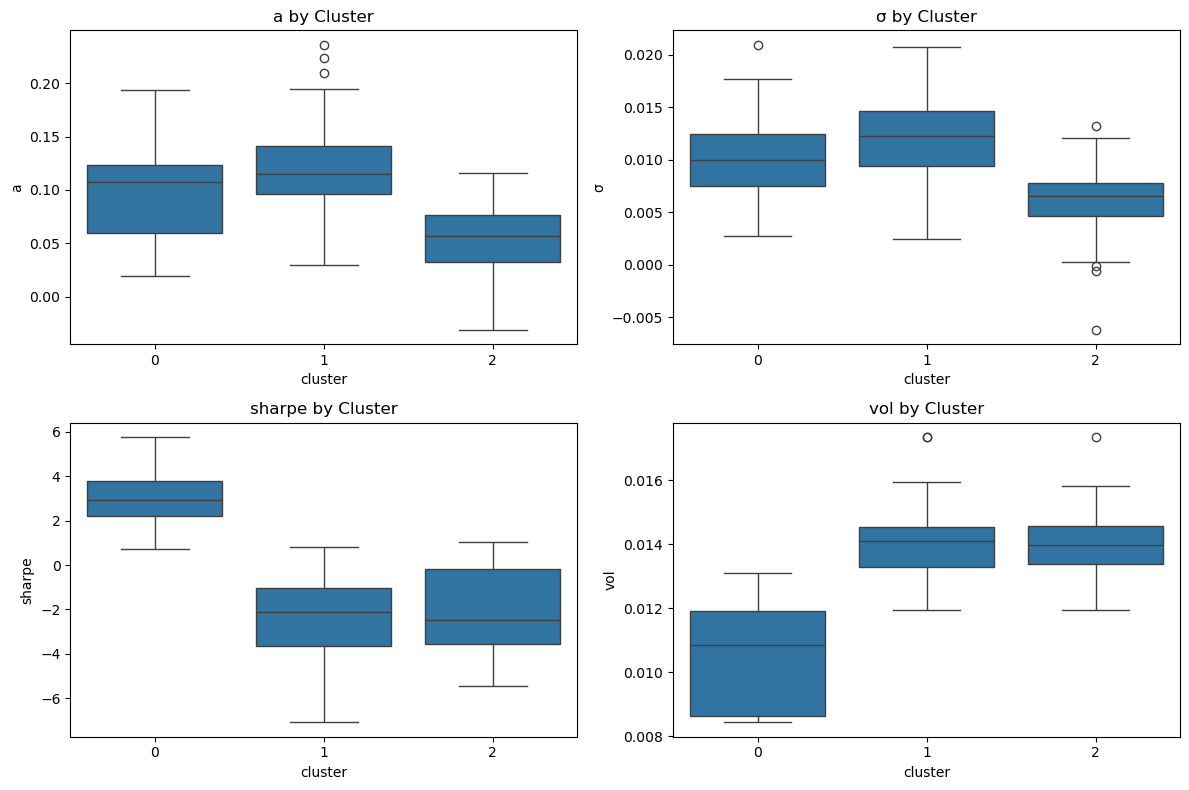

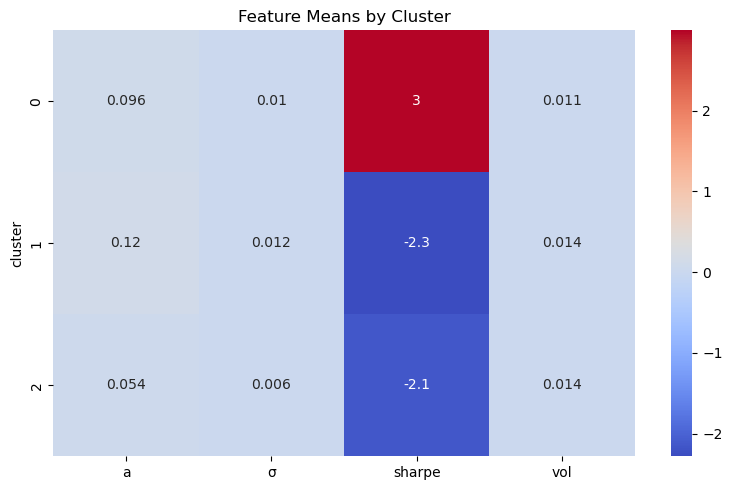


üìÇ Number of observations per cluster:
 cluster
0    42
1    93
2    36
Name: count, dtype: int64

üìà Strategy returns stats per cluster:
              mean       std  count
cluster                           
0        0.000073  0.000704     42
1       -0.000092  0.000830     93
2       -0.000200  0.000936     36


In [17]:
# Hull-White Model: Interest Rate Simulation and Applications

# Full combined version with all sections

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from statsmodels.graphics.tsaplots import plot_acf
import calendar
import yfinance as yf

# Load historical yield data (example: 1Y, 2Y, 5Y, 10Y)
# üì° Load real yield curve data from FRED
from fredapi import Fred
fred = Fred(api_key='c5eac556c7033d633c25a91225cea21c')  # –ó–∞–º–µ–Ω–∏—Ç–µ –Ω–∞ —Å–≤–æ–π API-–∫–ª—é—á —Å —Å–∞–π—Ç–∞ FRED

# –ó–∞–≥—Ä—É–∑–∫–∞ –∏—Å—Ç–æ—Ä–∏—á–µ—Å–∫–∏—Ö —Å—Ç–∞–≤–æ–∫: 1Y, 2Y, 5Y, 10Y
series = {
    '1Y': 'DGS1',
    '2Y': 'DGS2',
    '5Y': 'DGS5',
    '10Y': 'DGS10'
}
yield_data = pd.DataFrame({label: fred.get_series(code) for label, code in series.items()})
yield_data.index = pd.to_datetime(yield_data.index)
yield_data = yield_data.dropna()
yield_data = yield_data / 100  # convert from % to decimal

# –ò–Ω—Ç–µ—Ä–ø–æ–ª—è—Ü–∏—è –∫—Ä–∏–≤–æ–π –¥–æ—Ö–æ–¥–Ω–æ—Å—Ç–∏
maturities = np.array([1, 2, 5, 10])
latest_yields = yield_data.iloc[-1].values  # —É–∂–µ –≤ –¥–æ–ª—è—Ö
interp_yield = interp1d(maturities, latest_yields, kind='cubic', fill_value='extrapolate')

# üìê –ê–Ω–∞–ª–∏—Ç–∏—á–µ—Å–∫–∞—è —Ü–µ–Ω–∞ zero-coupon –æ–±–ª–∏–≥–∞—Ü–∏–∏ —á–µ—Ä–µ–∑ Hull-White

# –§—É–Ω–∫—Ü–∏–∏ B(t,T) –∏ A(t,T)
def B_hw(a, t, T):
    return (1 - np.exp(-a * (T - t))) / a

def A_hw(a, sigma, t, T):
    B = B_hw(a, t, T)
    part1 = sigma**2 / (4 * a) * (1 - np.exp(-2 * a * t)) * B**2
    return np.exp(part1)

# –¶–µ–Ω–∞ –æ–±–ª–∏–≥–∞—Ü–∏–∏ –≤ Hull-White
def P_HW(t, T, r_t, a, sigma):
    B = B_hw(a, t, T)
    A = A_hw(a, sigma, t, T)
    return A * np.exp(-B * r_t)

# –ü—Ä–∏–º–µ—Ä —Ä–∞—Å—á—ë—Ç–∞ —Ä—ã–Ω–æ—á–Ω—ã—Ö —Ü–µ–Ω ZCB
T_list = [1, 2, 5, 10]
market_prices = [np.exp(-y * T) for y, T in zip(latest_yields, T_list)]
r_t = latest_yields[0]  # —Ç–µ–∫—É—â–∞—è –∫—Ä–∞—Ç–∫–æ—Å—Ä–æ—á–Ω–∞—è —Å—Ç–∞–≤–∫–∞

# –ö–∞–ª–∏–±—Ä–æ–≤–∫–∞ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –º–æ–¥–µ–ª–∏ –ø–æ —Ü–µ–Ω–∞–º ZCB
def calibration_objective(params):
    a, sigma = params
    total_error = 0.0
    for T, market_price in zip(T_list, market_prices):
        model_price = P_HW(0, T, r_t, a, sigma)
        total_error += (market_price - model_price) ** 2
    return total_error

res = minimize(calibration_objective, [0.1, 0.01], bounds=[(0.001, 1), (0.0001, 0.05)])
a_calib, sigma_calib = res.x
print(f"‚úÖ –ö–∞–ª–∏–±—Ä–æ–≤–∞–Ω–Ω—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã: a = {a_calib:.4f}, sigma = {sigma_calib:.4f}")

# –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ zero-coupon price curve: P(0, t) = exp(-y(t) * t)
def zero_price(t):
    y = interp_yield(t)
    return np.exp(-y * t)

# –§–æ—Ä–≤–∞—Ä–¥–Ω–∞—è —Å—Ç–∞–≤–∫–∞: f(0, t) ‚âà -d ln P(0,t) / dt
def forward_rate(t, eps=1e-4):
    return -(np.log(zero_price(t + eps)) - np.log(zero_price(t))) / eps

# –§—É–Ω–∫—Ü–∏—è Œ∏(t) –≤ Hull-White –º–æ–¥–µ–ª–∏
def theta_hw(t, a, sigma):
    fwd = forward_rate(t)
    dfdt = (forward_rate(t + 1e-4) - forward_rate(t)) / 1e-4
    term3 = sigma**2 / (2 * a) * (1 - np.exp(-2 * a * t))
    return a * fwd + dfdt + term3

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è —Ñ–æ—Ä–≤–∞—Ä–¥–Ω–æ–π –∫—Ä–∏–≤–æ–π –∏ theta
t_grid = np.linspace(0.1, 10, 100)
f_grid = [forward_rate(t) for t in t_grid]
theta_grid = [theta_hw(t, a_calib, sigma_calib) for t in t_grid]

plt.figure(figsize=(10, 5))
plt.plot(t_grid, f_grid, label="Forward rate f(0,t)")
plt.plot(t_grid, theta_grid, label="Theta(t)", linestyle='--')
plt.title("Forward Curve and Œ∏(t) from Real Yield Data")
plt.xlabel("Maturity (Years)")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# –°—Ä–∞–≤–Ω–µ–Ω–∏–µ —Ü–µ–Ω ZCB
model_prices = [P_HW(0, T, r_t, a_calib, sigma_calib) for T in T_list]
print("\nüìä –°—Ä–∞–≤–Ω–µ–Ω–∏–µ —Ü–µ–Ω ZCB:")
for T, mkt, mdl in zip(T_list, market_prices, model_prices):
    diff = mdl - mkt
    print(f"{T}Y: Market = {mkt:.6f}, Model = {mdl:.6f}, Diff = {diff:.6e}")

# –°–∏–º—É–ª—è—Ü–∏—è Hull-White —Å —Ä–µ–∞–ª—å–Ω–æ–π Œ∏(t)

def simulate_hull_white_hw(a, sigma, r0, T, dt, n_paths):
    n_steps = int(T / dt)
    rates = np.zeros((n_paths, n_steps))
    theta_vals = np.zeros(n_steps)
    times = np.linspace(0, T, n_steps)

    # –ü—Ä–µ–¥–≤—ã—á–∏—Å–ª–∏–º Œ∏ –Ω–∞ –∫–∞–∂–¥–æ–º —à–∞–≥–µ
    for i, t in enumerate(times):
        theta_vals[i] = theta_hw(t, a, sigma)
    rates[:, 0] = r0

    for i in range(1, n_steps):
        dW = np.random.normal(0, np.sqrt(dt), n_paths)
        dr = a * (theta_vals[i] - rates[:, i-1]) * dt + sigma * dW
        rates[:, i] = rates[:, i-1] + dr

    return times, rates

# –ü–∞—Ä–∞–º–µ—Ç—Ä—ã —Å–∏–º—É–ª—è—Ü–∏–∏
T = 1.0      # 1 –≥–æ–¥
dt = 1/252   # —à–∞–≥ ‚Äî 1 —Ç–æ—Ä–≥–æ–≤—ã–π –¥–µ–Ω—å
n_paths = 1000
r0 = latest_yields[0]  # —Ç–µ–∫—É—â–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ –∫—Ä–∞—Ç–∫–æ—Å—Ä–æ—á–Ω–æ–π —Å—Ç–∞–≤–∫–∏

times, sim_rates = simulate_hull_white_hw(a_calib, sigma_calib, r0, T, dt, n_paths)

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è: –Ω–µ—Å–∫–æ–ª—å–∫–æ —Ç—Ä–∞–µ–∫—Ç–æ—Ä–∏–π + —Å—Ä–µ–¥–Ω—è—è
plt.figure(figsize=(12, 6))
for i in range(20):
    plt.plot(times, sim_rates[i], lw=0.7, alpha=0.6)
plt.plot(times, sim_rates.mean(axis=0), color='black', lw=2, label='Mean Rate')
plt.title("Hull‚ÄëWhite Rate Simulations (first 20 paths)")
plt.xlabel("Time (years)")
plt.ylabel("r(t)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# –ê–Ω–∞–ª–∏–∑: —Ä–µ–∞–ª–∏–∑–æ–≤–∞–Ω–Ω–∞—è –≤–æ–ª–∞—Ç–∏–ª—å–Ω–æ—Å—Ç—å - std rate across paths
realized_vol = sim_rates.std(axis=0)
plt.figure(figsize=(10, 4))
plt.plot(times, realized_vol)
plt.title("Realized Volatility of Simulated Rates")
plt.xlabel("Time (years)")
plt.ylabel("Std Dev of r(t)")
plt.grid(True)
plt.tight_layout()
plt.show()

# –ì–µ–Ω–µ—Ä–∞—Ü–∏—è —Å–∏–≥–Ω–∞–ª–∞ –Ω–∞ –æ—Å–Ω–æ–≤–µ —Å–∏–º—É–ª—è—Ü–∏–∏ —Å—Ç–∞–≤–æ–∫
# –°–∏–≥–Ω–∞–ª: –µ—Å–ª–∏ —Ç–µ–∫—É—â–∞—è —Å—Ç–∞–≤–∫–∞ –≤—ã—à–µ —Å—Ä–µ–¥–Ω–µ–π –ø–æ —Ç—Ä–∞–µ–∫—Ç–æ—Ä–∏–∏ ‚Äî —à–æ—Ä—Ç, –∏–Ω–∞—á–µ ‚Äî –ª–æ–Ω–≥

# –ë–µ—Ä–µ–º –ø–æ—Å–ª–µ–¥–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –ø—É—Ç–∏
final_rates = sim_rates[:, -1]
mean_final = np.mean(final_rates)
std_final = np.std(final_rates)

# –ò—Å–ø–æ–ª—å–∑—É–µ–º —Å—Ç—Ä–∞—Ç–µ–≥–∏—é –ø–æ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏—é –æ—Ç —Å—Ä–µ–¥–Ω–µ–≥–æ
# –ù–∞–ø—Ä–∏–º–µ—Ä: –µ—Å–ª–∏ r0 > mean_final + std ‚Äî short
#           –µ—Å–ª–∏ r0 < mean_final - std ‚Äî long
#           –∏–Ω–∞—á–µ ‚Äî flat

if r0 > mean_final + std_final:
    sim_signal = -1
elif r0 < mean_final - std_final:
    sim_signal = 1
else:
    sim_signal = 0

print(f"üìà –°–∏–≥–Ω–∞–ª –æ—Ç —Å–∏–º—É–ª—è—Ü–∏–∏ —Å—Ç–∞–≤–æ–∫: {sim_signal} (1=long, -1=short, 0=neutral)")
print(f"‚Üí r0 = {r0:.4f}, mean = {mean_final:.4f}, std = {std_final:.4f}")

# –°–æ–∑–¥–∞—ë–º –ø–æ–∑–∏—Ü–∏—é: —Å–∏–º—É–ª—è—Ü–∏—è —Ñ–∏–∫—Å–∏—Ä—É–µ—Ç –æ–¥–∏–Ω —Å–∏–≥–Ω–∞–ª –Ω–∞ –≤–µ—Å—å –ø–µ—Ä–∏–æ–¥
sim_position = pd.Series(sim_signal, index=rolling_dates)

# –î–æ—Ö–æ–¥–Ω–æ—Å—Ç—å —Å—Ç—Ä–∞—Ç–µ–≥–∏–∏ –Ω–∞ –æ—Å–Ω–æ–≤–µ —Å–∏–≥–Ω–∞–ª–∞
sim_strategy = sim_position.shift(1).fillna(0) * strategy_returns
sim_cumulative = (1 + sim_strategy).cumprod()

# –ú–µ—Ç—Ä–∏–∫–∏
sim_sharpe = sim_strategy.mean() / sim_strategy.std() * np.sqrt(252)
sim_drawdown = (sim_cumulative - sim_cumulative.cummax()).min()

# –í—ã–≤–æ–¥
print(f"\nüìä –°—Ç—Ä–∞—Ç–µ–≥–∏—è –Ω–∞ –æ—Å–Ω–æ–≤–µ Hull-White —Å–∏–º—É–ª—è—Ü–∏–∏:")
print(f"Sharpe: {sim_sharpe:.2f}")
print(f"Max Drawdown: {sim_drawdown:.2%}")

# –ì—Ä–∞—Ñ–∏–∫
plt.figure(figsize=(10, 5))
plt.plot(sim_cumulative, label=f'Hull-White Signal (Sharpe: {sim_sharpe:.2f})', color='purple')
plt.title("Cumulative Return: Hull-White Simulation Signal")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# –í—Å–µ —Å—Ç—Ä–∞—Ç–µ–≥–∏–∏
strategies = {
    "a": strat_a,
    "œÉ": strat_sigma,
    "combined": strat_comb,
    "simulated (HW)": sim_strategy
}

# –†–∞—Å—á—ë—Ç –º–µ—Ç—Ä–∏–∫
summary = []
for name, series in strategies.items():
    cumulative = (1 + series).cumprod()
    sharpe = series.mean() / series.std() * np.sqrt(252)
    drawdown = (cumulative - cumulative.cummax()).min()
    cagr = (cumulative.iloc[-1])**(252 / len(series)) - 1
    summary.append([name, sharpe, drawdown, cagr])

metrics_summary_df = pd.DataFrame(summary, columns=["Strategy", "Sharpe", "Max Drawdown", "CAGR"])

# –í—ã–≤–æ–¥
print("\nüìà Summary Table:")
print(metrics_summary_df.to_string(index=False))

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è
plt.figure(figsize=(10, 6))
sns.barplot(data=metrics_summary_df.melt(id_vars='Strategy'), x='value', y='variable', hue='Strategy', orient='h')
plt.title("Comparison of Strategy Metrics")
plt.xlabel("Metric Value")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Rolling –∞–Ω–∞–ª–∏–∑: Sharpe –∏ std –ø–æ –æ–∫–Ω—É
window = 30
rolling_metrics = {}
for name, series in strategies.items():
    rolling_sharpe = series.rolling(window).mean() / series.rolling(window).std() * np.sqrt(252)
    rolling_vol = series.rolling(window).std() * np.sqrt(252)
    rolling_metrics[name] = {
        "sharpe": rolling_sharpe,
        "volatility": rolling_vol
    }

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è Sharpe
plt.figure(figsize=(12, 6))
for name in strategies:
    plt.plot(rolling_metrics[name]["sharpe"], label=f"{name}")
plt.title("Rolling Sharpe Ratio (30 Days)")
plt.xlabel("Date")
plt.ylabel("Sharpe")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è Volatility
plt.figure(figsize=(12, 6))
for name in strategies:
    plt.plot(rolling_metrics[name]["volatility"], label=f"{name}")
plt.title("Rolling Volatility (30 Days)")
plt.xlabel("Date")
plt.ylabel("Annualized Volatility")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö –¥–ª—è –∫–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏–∏
features = pd.DataFrame({
    "a": rolling_a,
    "œÉ": rolling_sigma,
    "sharpe": rolling_sharpe_comb,
    "vol": strat_comb.rolling(30).std() * np.sqrt(252)
}).dropna()

# –°—Ç–∞–Ω–¥–∞—Ä—Ç–∏–∑–∞—Ü–∏—è
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# PCA (–¥–ª—è –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# –ö–ª–∞—Å—Ç–µ—Ä–∏–∑–∞—Ü–∏—è
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(X_scaled)

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è –∫–ª–∞—Å—Ç–µ—Ä–æ–≤
plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='Set1', alpha=0.7)
plt.title("Market Regime Clustering via K-Means (PCA Projection)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
plt.show()

# –î–æ–±–∞–≤–∏–º –∫–ª–∞—Å—Ç–µ—Ä—ã –≤ –¥–∞—Ç–∞—Ñ—Ä–µ–π–º
features["cluster"] = labels

# 11. –ê–Ω–∞–ª–∏–∑ –ø–æ –∫–ª–∞—Å—Ç–µ—Ä–∞–º

# 1. Boxplot –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ –∫–ª–∞—Å—Ç–µ—Ä–∞–º
plt.figure(figsize=(12, 8))
for i, col in enumerate(["a", "œÉ", "sharpe", "vol"]):
    plt.subplot(2, 2, i+1)
    sns.boxplot(x="cluster", y=col, data=features)
    plt.title(f"{col} by Cluster")
plt.tight_layout()
plt.show()

# 2. Heatmap ‚Äî —Å—Ä–µ–¥–Ω–∏–µ –∑–Ω–∞—á–µ–Ω–∏—è –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ –∫–ª–∞—Å—Ç–µ—Ä–∞–º
cluster_means = features.groupby("cluster").mean()
plt.figure(figsize=(8, 5))
sns.heatmap(cluster_means, annot=True, cmap="coolwarm")
plt.title("Feature Means by Cluster")
plt.tight_layout()
plt.show()

# 3. –ü–æ–¥—Å—á—ë—Ç —Ä–∞–∑–º–µ—Ä–æ–≤ –∫–ª–∞—Å—Ç–µ—Ä–æ–≤
counts = features["cluster"].value_counts().sort_index()
print("\nüìÇ Number of observations per cluster:\n", counts)

# 4. –°—Ä–∞–≤–Ω–µ–Ω–∏–µ –¥–æ—Ö–æ–¥–Ω–æ—Å—Ç–∏ —Å—Ç—Ä–∞—Ç–µ–≥–∏–∏ –≤ —Ä–∞–∑–Ω—ã—Ö —Ä–µ–∂–∏–º–∞—Ö
# (–¥–æ–ø—É—Å—Ç–∏–º strat_comb —Å–º–µ—â—ë–Ω –ø–æ rolling.date, –≤—ã—Ç—è–Ω–µ–º –∏–Ω–¥–µ–∫—Å—ã)
strat_comb_aligned = strat_comb.loc[features.index]
returns_by_cluster = strat_comb_aligned.groupby(features["cluster"]).agg(['mean', 'std', 'count'])
print("\nüìà Strategy returns stats per cluster:\n", returns_by_cluster)


# –û—Å—Ç–∞–ª—å–Ω—ã–µ –±–ª–æ–∫–∏ –æ—Å—Ç–∞—é—Ç—Å—è –±–µ–∑ –∏–∑–º–µ–Ω–µ–Ω–∏–π –¥–∞–ª—å—à–µ‚Ä¶
